In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

## Step 1. Download and compile the fpocket software from GitHub.
### Make sure you can reproduce the examples given.

#### input file as info.txt to check for druggability score

In [2]:
with open("Data/1ATP_info.txt") as f:
    lines = f.readlines()

## Step 2. Filter the pockets to keep only the ones with draggability > 0.5

In [3]:
for ind,i in enumerate(lines):
    if "Druggability Score" in i and float((i.split()[3])) > 0.5:
        print("Pocket with score > 0.5 is Pocket", lines[ind-2].split()[1])

Pocket with score > 0.5 is Pocket 1


## Step 3. Assume ONE pqr file is the input, which contains the alpha spheres defining the pocket.

In [4]:
filename = 'Data/1ATP_pockets.pqr'

with open(filename, 'r') as f:
    pqr_contents = f.read()

pqr_contents = pqr_contents.replace("HEADER\nHEADER This is a pqr format file writen by the programm fpocket.,,,, \nHEADER It contains all the pocket vertices found by fpocket.,,,,,","")

with open(filename.replace(".pqr", ".txt"), 'w') as f:
    f.write(pqr_contents)
    
filename_txt = filename.replace(".pqr", ".txt")

with open(filename_txt) as infile:
    # Read space-delimited file and replace all empty spaces by commas
    data = infile.read().replace('    ', ',')
    # Write the CSV data in the output file
    print(data, file=open(filename.replace(".pqr", ".txt"), 'w'))

df = pd.read_csv(filename_txt, sep=',',header=None)
df.rename(columns = {0:'Type',1:'Atom ID',2:'Element',3:'Pocket ID',4:'xyz',5:'__',6:'r'}, inplace = True)

df.head()

x = []
y = []
z = []

for i in range(len(df)):

    dummy = str(df['xyz'][i]).split(' ')
    filtered_list = [item for item in dummy if item != '']
    filtered_list = [item for item in filtered_list if item != 'nan']
    
    if len(filtered_list) < 3:
        x.append([])
        y.append([])
        z.append([])
    else:
        x.append(float(filtered_list[0]))
        y.append(float(filtered_list[1]))
        z.append(float(filtered_list[2]))
    
df['x']=x
df['y']=y
df['z']=z
df.drop(['xyz', '__'], axis=1,inplace = True)

pocket_1 = df[df['Pocket ID'] == 1]

## Step 4. Compute the bounding box (min/max xyz) of the alpha spheres, counting their centres and radii. Call it x_min and x_max (both are in R^3)

In [5]:
def min_max_center_margin():
    
    x_min = min(pocket_1['x']-pocket_1['r'])
    y_min = min(pocket_1['y']-pocket_1['r'])
    z_min = min(pocket_1['z']-pocket_1['r'])

    x_max = max(pocket_1['x']+pocket_1['r'])
    y_max = max(pocket_1['y']+pocket_1['r'])
    z_max = max(pocket_1['z']+pocket_1['r'])

    xyz_min = np.array([x_min,y_min,z_min])

    xyz_max = np.array([x_max,y_max,z_max])
    
    L = 5

    xyz_min_L = np.array([i - L for i in xyz_min])
    xyz_max_L = np.array([i + L for i in xyz_max])
    
    # Calculate the center point
    center = (xyz_min_L + xyz_max_L) / 2
    
    return xyz_min, xyz_min_L, xyz_max, xyz_max_L, L, center

In [6]:
def plot_max_min(xyz_min,xyz_max,L=None,center=None,use_L=False,use_center=False):

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    if use_center == True and use_L == True:
        ax.scatter([center[0], center[0]], [center[1], center[1]], [center[2], center[2]],c='g', marker='o')
        ax.scatter([xyz_min[0]-L, xyz_max[0]+L], [xyz_min[1]-L, xyz_max[1]+L], [xyz_min[2]-L, xyz_max[2]+L],c='b', marker='o')
        ax.scatter([xyz_min[0], xyz_max[0]], [xyz_min[1], xyz_max[1]], [xyz_min[2], xyz_max[2]],c='r', marker='x')

    if use_center == True and use_L == False:
        ax.scatter([center[0], center[0]], [center[1], center[1]], [center[2], center[2]],c='g', marker='o')
        ax.scatter([xyz_min[0], xyz_max[0]], [xyz_min[1], xyz_max[1]], [xyz_min[2], xyz_max[2]],c='r', marker='x')

    if use_center == False and use_L == True:
        ax.scatter([xyz_min[0]-L, xyz_max[0]+L], [xyz_min[1]-L, xyz_max[1]+L], [xyz_min[2]-L, xyz_max[2]+L],c='b', marker='o')
        ax.scatter([xyz_min[0], xyz_max[0]], [xyz_min[1], xyz_max[1]], [xyz_min[2], xyz_max[2]],c='r', marker='x')

    else:
        ax.scatter([xyz_min[0], xyz_max[0]], [xyz_min[1], xyz_max[1]], [xyz_min[2], xyz_max[2]],c='b', marker='o')
    
    # Set the plot limits and labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()

In [7]:
xyz_min, xyz_min_L, xyz_max, xyz_max_L, L, center = min_max_center_margin()

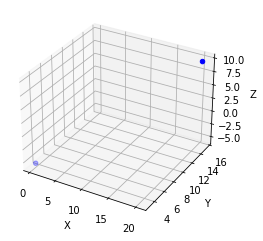

In [8]:
plot_max_min(xyz_min,xyz_max)

## Step 5. Add a margin L to each side of the bounding box.

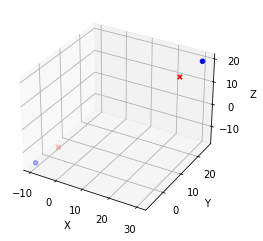

In [9]:
plot_max_min(xyz_min_L,xyz_max_L,L,use_L=True)

## Step 6. Find the center of the bounding box. x_0 (also in R^3)

The center of the bounding box is: [10.3085  9.2845  2.118 ]


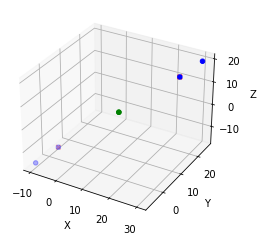

In [10]:
print("The center of the bounding box is:", center)
plot_max_min(xyz_min_L,xyz_max_L,L,center,use_L=True,use_center=True)

## Step 7. Compute the coordinates of an IMAGINARY 3d grid centred on x_0 . The grid spacing must be dX (given, but you can assume 1 Å). The grid must have enough points to cover the whole bounding box + L. The grid must be square, so round up as necessary. Please see the diagram attached. 

In [11]:
def compute_grid():
    # boundaries of box
    xyz_min_value = int(min(xyz_min_L))
    xyz_max_value = int(max(xyz_max_L))

    # step size
    dX = 1  

    # array dimension of box
    n = np.array([xyz_min_value + i*dX for i in range((xyz_max_value-xyz_min_value)//dX + 1)])

    coordinates = np.array([(i, j, l) for i in n for j in n for l in n])

    return coordinates

In [12]:
coordinates = compute_grid()

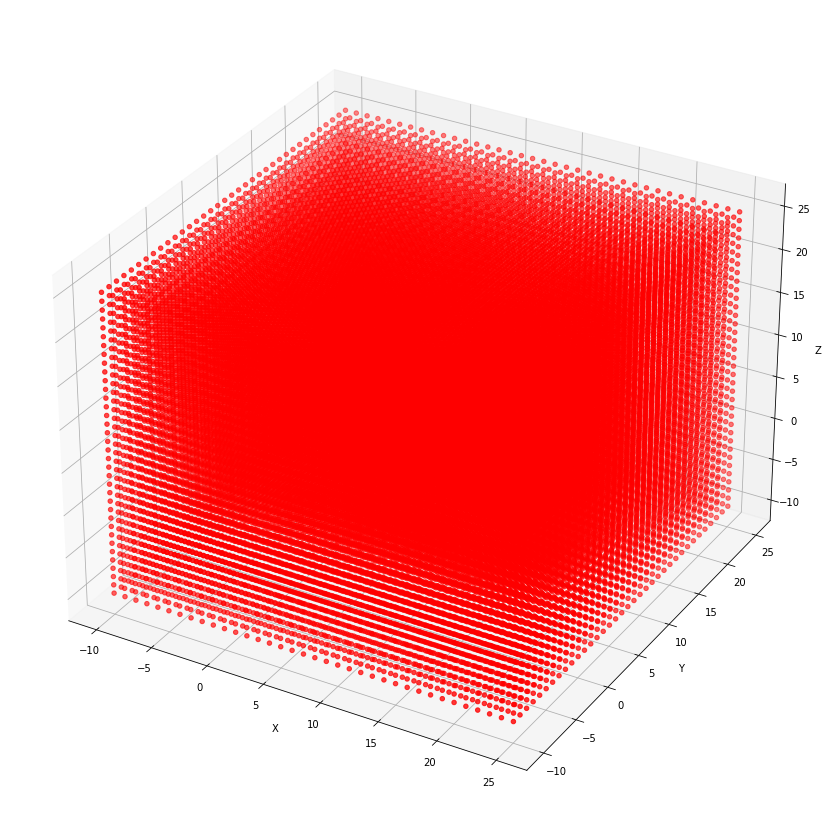

[10.3085  9.2845  2.118 ]


In [13]:
# Create a 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Plot the grid of points
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c='r')
center = (xyz_min_L + xyz_max_L) / 2
ax.scatter([center[0], center[0]], [center[1], center[1]], [center[2], center[2]],c='g', marker='o')


# Set the plot limits and labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()
print(center)

## Step 8. Each cell of the grid will have its coordinates, x_i. For each cell, compute its value v_i as follows: if x_i is inside any alpha-sphere, assign 1, otherwise 0. 

In [14]:
def voxelized_space():
    # instead of 1 put the radius of alpha sphere
    X,Y,Z = pocket_1['x'],pocket_1['y'],pocket_1['z']

    # Combine the vectors into a matrix
    pocket_matrix = np.array([X, Y, Z]).T

    inside = []

    # Compare the elements of the two matrices
    for ind_p, p in enumerate(pocket_matrix):
        for ind, i in enumerate(coordinates):
            if np.abs(i - p)[0] < pocket_1['r'][ind_p] and np.abs(i - p)[1] < pocket_1['r'][ind_p] and np.abs(i - p)[2] < pocket_1['r'][ind_p]:
                inside.append([i,1])
            else:
                inside.append([i,0])

    # Extract the coordinates and values from the sublists
    coords = np.array([lst_elem[0] for lst_elem in inside])
    values = np.array([lst_elem[1] for lst_elem in inside])

    # Define the list of sphere sizes
    radii = pocket_1['r']
    
    return coords, values, radii, inside

In [15]:
coords, values, radii, inside_matrix = voxelized_space()

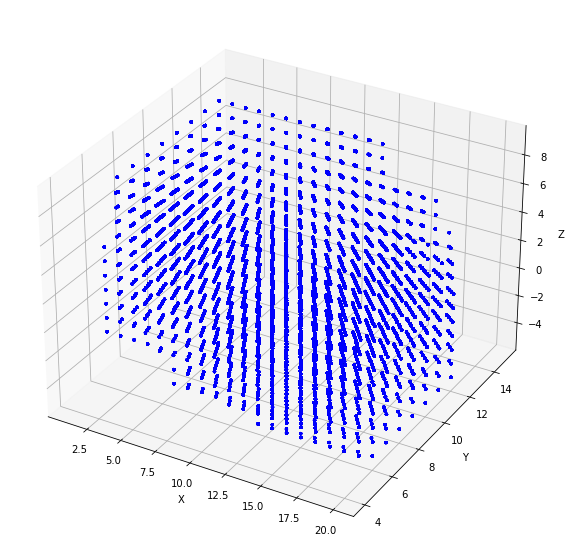

In [16]:
# Plot the spheres with their radius
# Create a 3D scatter plot of the points with red for value 0 and blue for value 1
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Loop through the sphere sizes and plot the points
for radius in radii:
    ax.scatter(coords[values == 1, 0], coords[values == 1, 1], coords[values == 1, 2], c='b', s=radius)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Interactive plot with rotation and zooming

<IPython.core.display.Javascript object>


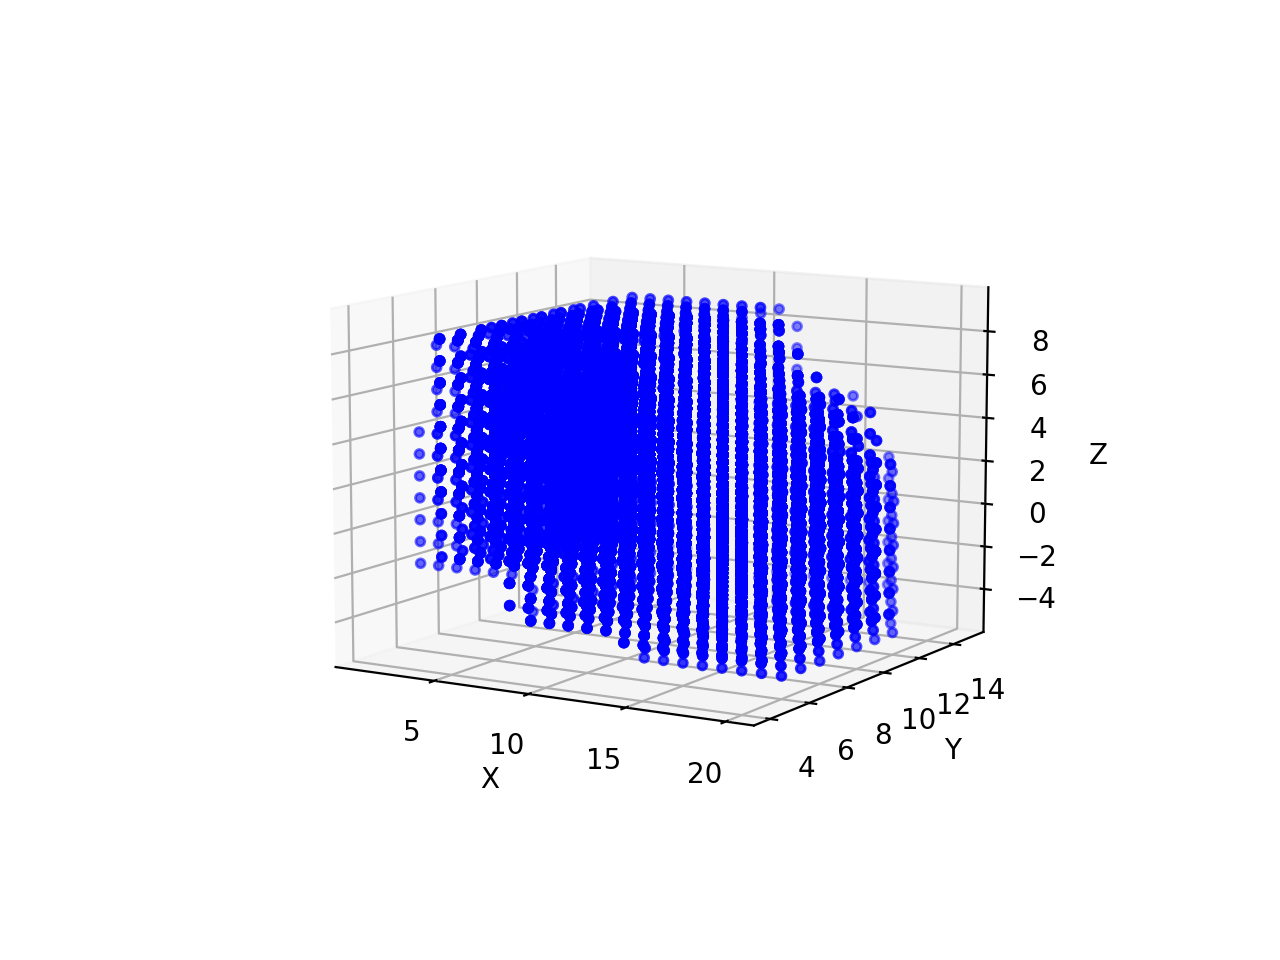

In [18]:
%matplotlib notebook

# Extract the coordinates and values from the sublists
coords = np.array([lst_elem[0] for lst_elem in inside_matrix])
values = np.array([lst_elem[1] for lst_elem in inside_matrix])

# Plot the spheres with their radius
# Create a 3D scatter plot of the points with red for value 0 and blue for value 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[values == 1, 0], coords[values == 1, 1], coords[values == 1, 2], c='b',s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## Step 9. It should be implemented as  a Python  function. Return the grid (i.e. its coordinates, bounding box, values etc) as an object or dictionary of your choice.

In [19]:
def inside_pocket(pocket_1):
    
    xyz_min, xyz_min_L, xyz_max, xyz_max_L, L, center = min_max_center_margin()
    
    coordinates = compute_grid()
    
    coords, values, radii, inside_matrix = voxelized_space()

    coords = np.array([lst_elem[0] for lst_elem in inside_matrix])
    values = np.array([lst_elem[1] for lst_elem in inside_matrix])
    
    inside_dict = {"coordinates": coords, "values": values, "center": center, "margin": L, "maximum": xyz_max_L, "minimum": xyz_min_L}
    
    return inside_dict
    

In [20]:
data = inside_pocket(pocket_1)

## Step 10. Write the grid as a numpy object and, if possible, as a OpenDX  grid file (format described here). This is the goal of the project.

In [21]:
data

{'coordinates': array([[-10, -10, -10],
        [-10, -10,  -9],
        [-10, -10,  -8],
        ...,
        [ 25,  25,  23],
        [ 25,  25,  24],
        [ 25,  25,  25]]),
 'values': array([0, 0, 0, ..., 0, 0, 0]),
 'center': array([10.3085,  9.2845,  2.118 ]),
 'margin': 5,
 'maximum': array([25.348, 20.401, 14.613]),
 'minimum': array([ -4.731,  -1.832, -10.377])}

In [ ]:
# # Create the OpenDX file as a string
# dx_file = "object 1 class gridpositions counts {} {} {}\n".format(data['coordinates'].shape[0], 1, 1)
# dx_file += "origin {} {} {}\n".format(data['center'][0] - data['margin'], data['center'][1] - data['margin'], data['center'][2] - data['margin'])
# dx_file += "delta {} 0 0\n".format(2 * data['margin'] / data['coordinates'].shape[0])
# dx_file += "delta 0 {} 0\n".format(2 * data['margin'] / data['coordinates'].shape[1])
# # dx_file += "delta 0 0 {}\n".format(2 * data['margin'] / data['coordinates'].shape[2])
# dx_file += "object 2 class gridconnections counts {} {} {}\n".format(data['coordinates'].shape[0], 1, 1)
# dx_file += "object 3 class array type double rank 0 items {} data follows\n".format(data['coordinates'].shape[0])
# dx_file += " ".join([str(x) for x in data['values']]) + "\n"
# dx_file += "attribute \"dep\" string \"positions\"\n"
# dx_file += "object \"regular positions\" class field\n"
# dx_file += "component \"positions\" value 1\n"
# dx_file += "component \"connections\" value 2\n"
# dx_file += "component \"data\" value 3"

# # Write the OpenDX file to disk
# with open("data.dx", "w") as f:
#     f.write(dx_file)